In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [2]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [16]:
origin=load_data('language_math_scores')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab11_/language_math_scores.xlsx
[desc] 어느 학급의 언어영역과 수리영역 점수를 기록한 가상의 데이터 셋

field     type    description
--------  ------  -------------
언어영역  INT     언어영역 점수
수리영역  INT     수리영역 점수


===== 데이터 크기 확인 =====
데이터셋 크기 : (50, 2)
행 개수 : 50개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   언어영역    50 non-null     int64
 1   수리영역    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,언어영역,수리영역
0,66,66
1,58,70
2,73,74
3,52,58
4,72,79


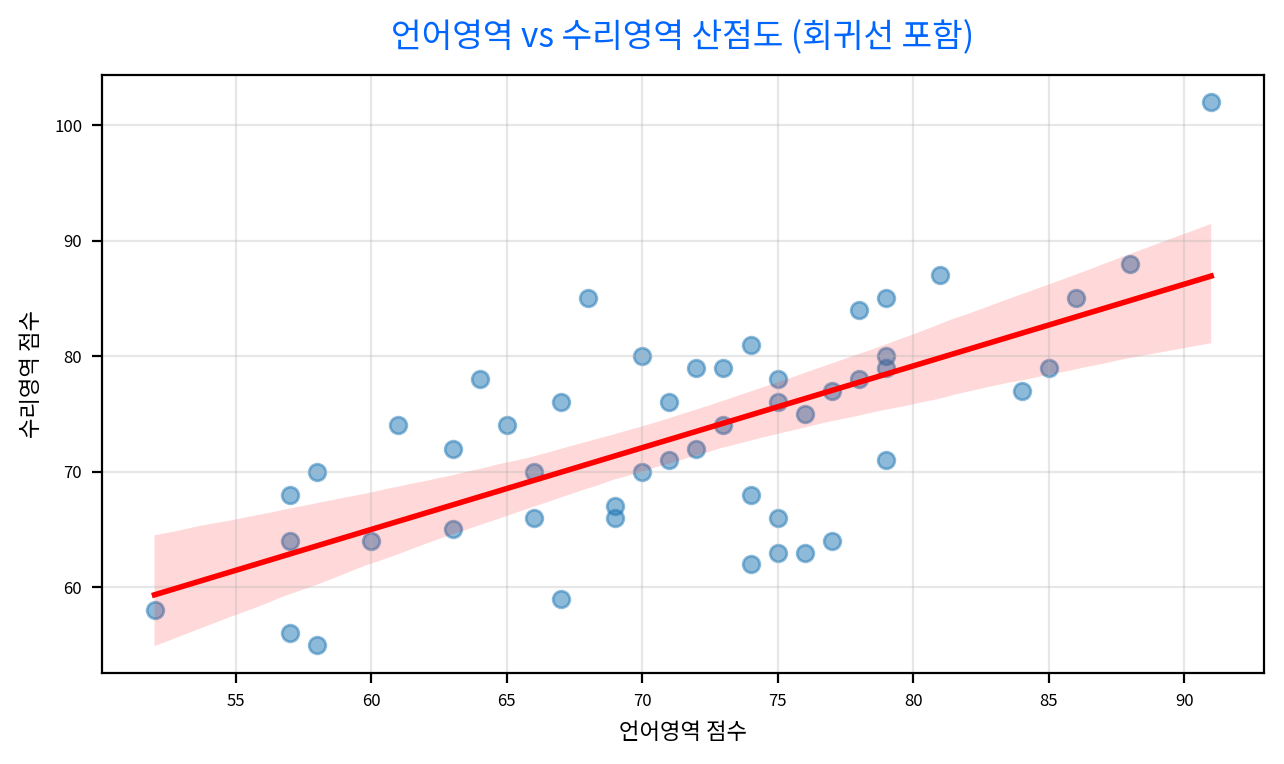

In [ ]:
width_px=1280
height_px=760
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='언어영역', y='수리영역', scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'linewidth':2})

ax.grid(True, alpha=0.3)
ax.set_title('언어영역 vs 수리영역 산점도 (회귀선 포함)', color='#0066ff', fontsize=12, fontweight=1000, pad=10)
ax.set_xlabel('언어영역 점수', fontsize=8)
ax.set_ylabel('수리영역 점수', fontsize=8)

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

In [9]:
x=origin['언어영역']
y=origin['수리영역']

X=sm.add_constant(x)
model=sm.OLS(y,X).fit()
reset=linear_reset(model, power=2, use_f=True)

linearity_ok=reset.pvalue>0.05
print(f'Ramsey RESET Test : {"선형성 적합" if linearity_ok else "선형성 위반"} (p-value : {reset.pvalue:.4f})')

Ramsey RESET Test : 선형성 적합 (p-value : 0.1884)


In [10]:
# 이상치와 왜도 검정
data=origin[['언어영역', '수리영역']]
results={}

for col in data.columns:
    temp=data[col].dropna()

    # 왜도 계산
    skew_original=temp.skew()

    # Z-score 기반 이상치 탐지 (|z|>3)
    z_scores=zscore(temp)
    outlier_count=int(np.sum(np.abs(z_scores)>3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log=np.log1p(temp-temp.min()+1)
    skew_log=data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log=(abs(skew_original)>1) and (abs(skew_log)<abs(skew_original))

    results[col]={
        'original_skew':skew_original,
        'log_skew':skew_log,
        'outliers(|z|>3)':outlier_count,
        'log_recommended':need_log
    }

results_df=pd.DataFrame(results).T
display(results_df)

outlier_flag=len((results_df['outliers(|z|>3)']>0))>0
if outlier_flag:
    print('이상치가 발견되어 스피어만 상관계수 사용')
else:
    print('이상치가 발견되지 않아 피어슨 상관계수 사용')

,original_skew,log_skew,outliers(|z|>3),log_recommended
언어영역,-0.102559,-1.735952,0,False
수리영역,0.367414,-1.529107,1,False


이상치가 발견되어 스피어만 상관계수 사용


In [11]:
pearson_r, pearson_p=pearsonr(origin['언어영역'], origin['수리영역'])
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(pearson_r, pearson_p, '대립' if pearson_p<=0.05 else '귀무')

'statistic: 0.671, p-value: 0.000, 대립가설 채택'

In [12]:
spearman_r, spearman_p=spearmanr(origin['언어영역'], origin['수리영역'])
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(spearman_r, spearman_p, '대립' if spearman_p<=0.05 else '귀무')

'statistic: 0.599, p-value: 0.000, 대립가설 채택'

In [13]:
if linearity_ok and not outlier_flag:
    chosen='pearson'
    corr, pval=pearson_r, pearson_p
    rationale='선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen='spearman'
    corr, pval=spearman_r, spearman_p
    rationale='비선형(또는 이상치 영향) 가능성 고려'

print('='*50)
print('📊 상관계수 요약')
print('='*50)
print(f'Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}')
print(f'Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}')

print('\n'+'='*50)
print('✅ 최종 선택 결과')
print('='*50)
print(f'선택된 방법: {chosen}')
print(f'상관계수: {corr:.3f}')
print(f'p-value: {pval:.4f}')
print(f'선택 근거: {rationale}')
print('='*50)

📊 상관계수 요약
Pearson r: 0.671, p-value: 0.0000
Spearman rho: 0.599, p-value: 0.0000

✅ 최종 선택 결과
선택된 방법: spearman
상관계수: 0.599
p-value: 0.0000
선택 근거: 비선형(또는 이상치 영향) 가능성 고려


In [14]:
corr_matrix=origin[['언어영역', '수리영역']].corr(method=chosen)
corr_matrix

,언어영역,수리영역
언어영역,1.000000,0.599095
수리영역,0.599095,1.000000


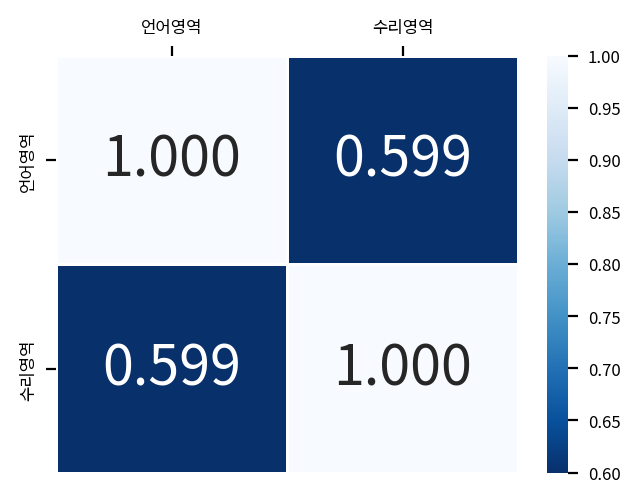

In [15]:
width_px=650
height_px=500
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})

ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()